# アニーリングを用いたクラスタリング

このチュートリアルでは、アニーリングの応用の一例としてPyQUBOとOpenjijを利用したクラスタリングを取り上げます。  

## クラスタリング

クラスタリングとは与えられたデータを$n$個のクラスターに分けるというタスクです($n$は外部から与えられているとします)。簡単のため、今回はクラスター数が2を考えましょう。

### クラスタリングのハミルトニアン
今回は、以下のハミルトニアンを最小化することでクラスタリングを行います。

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j} (1 - \sigma _i \sigma_j)
$$

$i, j$はサンプルの番号、$d_{i,j}$は２つのサンプル間の距離、$\sigma_i=\{-1,1\}$は２つのクラスターのどちらかに属しているかを表すスピン変数です。  
このハミルトニアンの和の各項は   

- $\sigma_i  = \sigma_j $のとき、0
- $\sigma_i  \neq \sigma_j $のとき、$d_{i,j}$  

となります。右辺のマイナスに注意すると、ハミルトニアン全体では「異なるクラスに属しているサンプル同士の距離を最大にする$\{\sigma _1, \sigma _2 \ldots \}$の組を選びなさい」という問題に帰着することがわかります。

##  JijModelingとOpenJijを用いたクラスタリング

### 変数定義

JijModelingを用いて、上述のハミルトニアンを定式化しましょう。
そのために必要となる変数を定義します。
JijModelingでは、スピン変数$\sigma_i$を扱えないため、バイナリ変数$x_i$で書けるように、$\sigma_i = 2x_i - 1$という関係を用いて書き直します。

In [17]:
import jijmodeling as jm

d = jm.Placeholder("d", ndim=2)
N = d.len_at(0, latex="N")
x = jm.BinaryVar("x", shape=(N, ))
i = jm.Element("i", belong_to=(0, N))
j = jm.Element("j", belong_to=(0, N))
sigma_i = 2 * x[i] - 1
sigma_j = 2 * x[j] - 1

### 目的関数の実装

先ほどのハミルトニアンを実装します。

In [19]:
problem = jm.Problem("Clustering")
problem += - jm.sum([i, j], d[i, j]*(1-sigma_i*sigma_j))

実装された数理モデルを、Jupyter Notebookで表示してみましょう。

In [20]:
problem

### インスタンスの作成

今回は人工的に二次元平面上の明らかに線形分離可能なデータを生成しましょう。

In [21]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix

data = []
label = []
for i in range(100):
    # [0, 1]の乱数を生成
    p = np.random.uniform(0, 1)
    # ある条件を満たすときをクラス1、満たさないときを-1
    cls =1 if p>0.5 else -1
    # ある座標を中心とする正規分布に従う乱数を作成
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
# DataFrameとして整形
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label
instance_data = {'d': distance_matrix(df1, df1)}

生成されたデータを可視化してみます。

<Axes: xlabel='x', ylabel='y'>

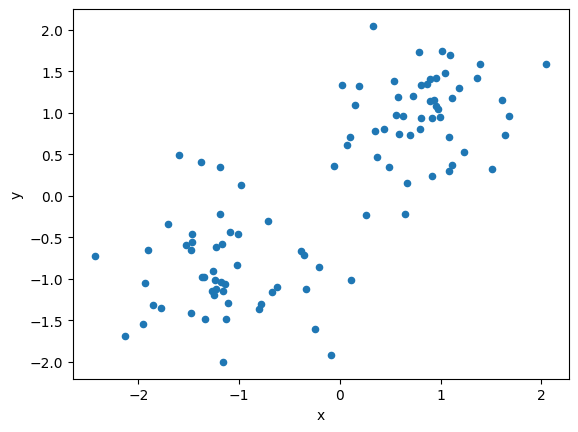

In [22]:
# データセットの可視化
df1.plot(kind='scatter', x="x", y="y")

### JijModeling TranspilerによるPyQUBOへの変換

ここまで行われてきた実装は、全てJijModelingによるものでした。
これをPyQUBOに変換することで、OpenJijはもちろん、他のソルバーを用いた組合せ最適化計算を行うことが可能になります。

In [23]:
import jijmodeling_transpiler as jmt

# compile
compiled_model = jmt.core.compile_model(problem, instance_data, {})
# get qubo model
pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model=compiled_model, relax_method=jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)
qubo, const = pubo_builder.get_qubo_dict(multipliers={})

### OpenJijによる求解

Openjijを用いて、最適化問題を解いてみましょう。

In [24]:
import openjij as oj

# set sampler
sampler = oj.SASampler()
# solve problem
result = sampler.sample_qubo(qubo, num_reads=100)

計算結果をデコードします。
また得られた解の中から目的関数値が最小のものを選び出し、それを可視化してみましょう。

Text(0, 0.5, 'y')

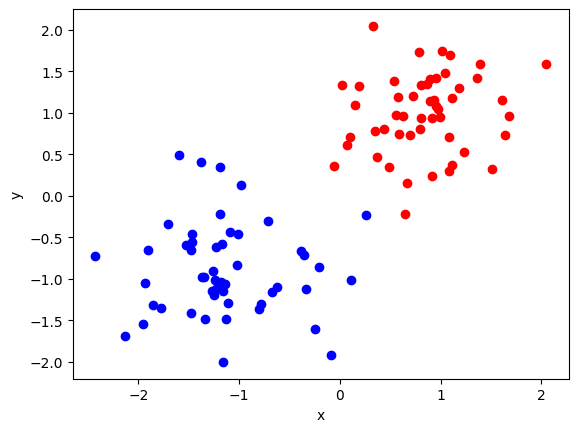

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(result, pubo_builder, compiled_model)
objectives = [objective for objective in sampleset.evaluation.objective]
lowest_index = np.argmin(objectives)
# visualize solution
for idx in range(0, len(instance_data['d'])):
    if idx in sampleset.record.solution["x"][lowest_index][0][0]:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")
plt.xlabel('x')
plt.ylabel('y')

赤と青の2つのクラスに分類できていることがわかります。